In [ ]:
import os

import pandas as pd

from tqdm.notebook import tqdm

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

#Download Dataset

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2'
od.download(dataset_url)

100%|██████████| 4.10G/4.10G [00:34<00:00, 129MB/s]


#Prepare Dataset

In [ ]:
class DepthDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform1, transform2):
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.csv_file.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        depth_path = os.path.join(self.root_dir, self.csv_file.iloc[index, 1])
        depth_map = Image.open(depth_path).convert('L')

        image = self.transform1(image)
        depth_map = self.transform2(depth_map)

        return image, depth_map

In [ ]:
train_dir = '/content/nyu-depth-v2/nyu_data'
test_dir = '/content/nyu-depth-v2/nyu_data'

train_csv = pd.read_csv('/content/nyu-depth-v2/nyu_data/data/nyu2_train.csv')
train_csv = train_csv[:9600]
test_csv = pd.read_csv('/content/nyu-depth-v2/nyu_data/data/nyu2_test.csv')
test_csv = test_csv[:640]

In [ ]:
image_size = (228, 304)
depth_map_size = (55, 74)
batch_size = 128

In [ ]:
transform_img = transforms.Compose([transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_depth = transforms.Compose([transforms.Resize(depth_map_size),
                          transforms.CenterCrop(depth_map_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5), (0.5))])

In [ ]:
train_ds = DepthDataset(train_csv, train_dir, transform_img, transform_depth)
test_ds = DepthDataset(test_csv, test_dir, transform_img, transform_depth)

In [ ]:
len(train_ds), len(test_ds)

(9600, 640)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

In [ ]:
len(train_dl), len(test_dl)

(75, 5)

#Visualize Examples

In [ ]:
stats_img = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats_dmaps = (0.5), (0.5)

In [ ]:
def denorm1(img_tensors):
    return img_tensors * stats_img[1][0] + stats_img[0][0]

def denorm2(dmap_tensors):
    return dmap_tensors * stats_dmaps[1] + stats_dmaps[0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm1(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_dmaps(depth_maps, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm2(depth_maps.detach()[:nmax]), nrow=8).permute(1, 2, 0), cmap='gray')

def show_batch(dl, nmax=64):
    for images, depth_maps in dl:
        show_images(images, nmax)
        show_dmaps(depth_maps, nmax)
        break

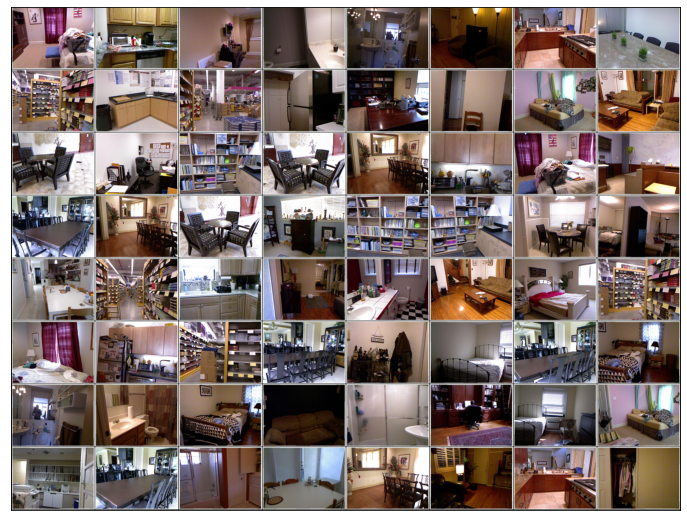

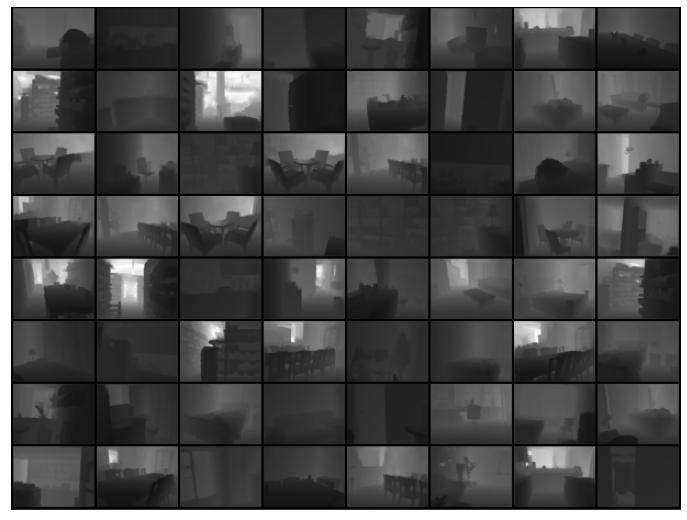

In [ ]:
show_batch(train_dl)

#Device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

#Global Coarse-Scale Network

In [ ]:
class CoarseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # in: 3 x 228 x 304

            nn.Conv2d(3, 96, kernel_size = 11, stride = 4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 96 x 27 x 37

            nn.Conv2d(96, 256, kernel_size = 5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 256 x 13 x 18

            nn.Conv2d(256, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # out: 384 x 13 x 18

            nn.Conv2d(384, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # out: 384 x 13 x 18

            nn.Conv2d(384, 256, kernel_size = 3, stride = 2),
            nn.ReLU(),
            # out: 256 x 6 x 8

            nn.Flatten(1, 3),
            nn.Linear(256*6*8, 4096),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(4096, 4070)
        )

    def forward(self, img):
        coarse = self.network(img)
        return torch.reshape(coarse, (batch_size, 1, 55, 74))

In [ ]:
coarse_model = CoarseNetwork()

#Local Fine-Scale Network

In [ ]:
class FineNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network1 = nn.Sequential(
            # in: 3 x 304 x 228

            nn.Conv2d(3, 63, kernel_size = 9, stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 63 x 74 x 55  
        )
        self.network2 = nn.Sequential(
            # in: 64 x 74 x 55

            nn.Conv2d(64, 64, kernel_size = 5, padding = 2),
            nn.ReLU(),
            # out: 64 x 74 x55

            nn.Conv2d(64, 1, kernel_size = 5, padding = 2)
            # out: 1x 74 x55
        )
            
    def forward(self, img, coarse):
        fine = self.network1(img)
        fine = torch.cat((fine, coarse), dim = 1)
        return self.network2(fine)

In [ ]:
fine_model = FineNetwork()

#Loss Function

In [ ]:
n = batch_size * 74 * 55

In [ ]:
def train_loss(pred, output):
    # Convert image into a numpy array
    norm_pred = pred
    norm_pred = norm_pred.cuda().detach().cpu().numpy()
    norm_output = output.numpy()

    # Normalize the image between 0-255
    norm_pred = cv2.normalize(norm_pred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_output = cv2.normalize(norm_output, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

    di = np.log(norm_pred+1) - np.log(norm_output+1)
    di2 = np.square(di)

    loss = [np.sum(di2/n) - (0.5) * np.square(np.sum(di/n))]

    return torch.Tensor(loss)

In [ ]:
pred = torch.randn(64, 3, 74, 55)
output = torch.randn(64, 3, 74, 55)
train_loss(pred, output)

RuntimeError: ignored

In [ ]:
def scale_invariant_error(pred, output):
    # Convert image into a numpy array
    norm_pred = pred
    norm_pred = norm_pred.cuda().detach().cpu().numpy()
    norm_output = output.numpy()

    # Normalize the image between 0-255
    norm_pred = cv2.normalize(norm_pred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_output = cv2.normalize(norm_output, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

    di = np.log(norm_pred+1) - np.log(norm_output+1)
    di2 = np.square(di)

    error = np.sum(di2/n) - np.square(np.sum(di/n))

    return error

#Training The Coarse Network

In [ ]:
epochs = 1
lr = 0.0001

In [ ]:
def train_coarse(epochs, lr, coarse_model, train_dl, opt_func = torch.optim.Adam):
    optimizer = opt_func(coarse_model.parameters(), lr)

    # Load the model into the GPU
    coarse_model = coarse_model.to(device)

    coarse_model.train()

    for epoch in range(epochs):
        coarse_losses = []
        for imgs, dmaps in tqdm(train_dl):

            # Move data into the GPU
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)
            preds = coarse_model(imgs)

            loss = train_loss(preds, dmaps)
            print(loss)
            coarse_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

        coarse_losses = torch.Tensor(coarse_losses)
        avg_loss = torch.mean(coarse_losses)
        print('Loss: ' + avg_loss)

In [ ]:
train_coarse(epochs, lr, coarse_model, train_dl)

  0%|          | 0/75 [00:00<?, ?it/s]

#Training The Fine Network

In [ ]:
def train_fine(epochs, lr, fine_model, train_dl, opt_func = torch.optim.Adam):
    optimizer = opt_func(fine_model.parameters(), lr)
    criterion = train_loss()

    # Load the model into the GPU
    fine_model = fine_model.to(device)

    fine_model.train()
    coarse_model.eval()
    fine_losses = []

    for epoch in range(epochs):
        for imgs, dmaps in tqdm(train_dl):

            coarse_outputs = coarse_model(imgs)

            # Move data into the GPU
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)
            coarse_outputs = coarse_outputs.to(device)

            preds = fine_model(imgs, coarse_outputs)
            loss = train_loss(preds, dmaps).requires_grad()

            fine_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

        avg_loss = np.mean(fine_losses)
        print('Loss: ' + str(avg_loss))

In [ ]:
train_coarse(epochs, lr, fine_model, train_dl)

#Results

In [ ]:
def evaluate(coarse_model, fine_model, test_dl):
    errors = []
    si_errors = []
    rmse_errors = []

    for imgs, dmaps in tqdm(test_dl):
        coarse_outputs = coarse_model(imgs)
        preds = fine_model(imgs, coarse_outputs)

        error = train_loss(preds, dmaps)
        si_error = scale_invariant_error(preds, dmaps)
        rmse_error = torch.sqrt(nn.MSELoss(preds, dmaps))

        errors.append(error)
        si_errors.append(si_error)
        rmse_errors.appens(rmse_error)

    avg_error = np.mean(errors)
    avg_si_error = np.mean(si_errors)
    avg_rmse_error = np.mean(rmse_errors)

    print('error: {}, scale invariant error: {}, root mean squared error: {}'.format(avg_error, avg_si_error, avg_rmse_error))

In [ ]:
img0, dmap0 = test_ds[0]

img0 = transform_img(img0)
dmap0 = transform_depth(dmap0)

coarse0 = coarse_model(img0)
fine0 = fine_model(img0, coarse0)

In [ ]:
coarse0 = Image.open(coarse0)
coarse0.show()

In [ ]:
fine0 = Image.open(fine0)
fine0.show()